# setup

In [1]:
# Hackernews GitHub Project Timeline Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import time
from dateutil.parser import parse
from tqdm.notebook import tqdm
import re
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from urllib.parse import urlparse
import os

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")


In [2]:
# 1. Load the Hackernews data
def load_hn_data(filepath):
    """Load Hackernews story data from CSV."""
    df = pd.read_csv(filepath)

    # Convert Unix timestamp to datetime
    df['submission_date'] = pd.to_datetime(df['date'], unit='s')

    # Extract GitHub username and repo name from URL
    def extract_github_info(url):
        try:
            if not isinstance(url, str) or 'github.com' not in url:
                return None, None

            parsed = urlparse(url)
            if parsed.netloc != 'github.com':
                return None, None

            path_parts = [p for p in parsed.path.split('/') if p]
            if len(path_parts) >= 2:
                return path_parts[0], path_parts[1]
            return None, None
        except:
            return None, None

    # Apply extraction to create new columns
    df[['github_username', 'github_repo']] = df.apply(
        lambda row: pd.Series(extract_github_info(row['url'])), axis=1
    )

    # Filter only GitHub repositories
    github_df = df[df['github_username'].notna() & df['github_repo'].notna()].copy()

    # Create full repo name column (username/repo)
    github_df['full_repo_name'] = github_df['github_username'] + '/' + github_df['github_repo']

    return github_df


In [3]:
# 2. Fetch GitHub repository metadata
def fetch_github_repo_metadata(repo_list, token=None):
    """
    Fetch metadata for GitHub repositories, focusing on creation dates.

    Args:
        repo_list: List of repositories in format 'username/reponame'
        token: GitHub API token (optional but recommended to avoid rate limits)

    Returns:
        DataFrame with repository metadata
    """
    headers = {}
    if token:
        headers['Authorization'] = f'token {token}'
    else:
        print("Warning: No GitHub token provided. API rate limits may apply.")

    repo_data = []

    for repo in tqdm(repo_list, desc="Fetching GitHub metadata"):
        try:
            url = f'https://api.github.com/repos/{repo}'
            response = requests.get(url, headers=headers)

            if response.status_code == 200:
                data = response.json()
                repo_info = {
                    'full_repo_name': repo,
                    'created_at': data.get('created_at'),
                    'updated_at': data.get('updated_at'),
                    'stars': data.get('stargazers_count', 0),
                    'forks': data.get('forks_count', 0),
                    'language': data.get('language'),
                    'description': data.get('description')
                }
                repo_data.append(repo_info)
            else:
                print(f"Failed to fetch data for {repo}: {response.status_code}")

            # Respect GitHub's rate limit
            time.sleep(1)

        except Exception as e:
            print(f"Error fetching data for {repo}: {str(e)}")

    # Create DataFrame from collected data
    metadata_df = pd.DataFrame(repo_data)

    # Convert string dates to datetime
    if not metadata_df.empty:
        metadata_df['repo_created_at'] = pd.to_datetime(metadata_df['created_at'])
        metadata_df['repo_updated_at'] = pd.to_datetime(metadata_df['updated_at'])

    return metadata_df


In [4]:
# 3. Merge HN data with GitHub metadata
def merge_datasets(hn_df, github_df):
    """Merge Hackernews data with GitHub repo metadata."""
    # Merge on the full repo name
    merged_df = hn_df.merge(github_df, on='full_repo_name', how='left')

    # Ensure both datetime fields have the same timezone handling
    # They should both be UTC by now, but this is a safeguard
    if 'submission_date' in merged_df.columns and 'repo_created_at' in merged_df.columns:
        # Make sure both are timezone aware with UTC
        if merged_df['submission_date'].dt.tz is None:
            merged_df['submission_date'] = merged_df['submission_date'].dt.tz_localize('UTC')
        if merged_df['repo_created_at'].dt.tz is None:
            merged_df['repo_created_at'] = merged_df['repo_created_at'].dt.tz_localize('UTC')

    # Calculate time difference between repo creation and HN submission
    merged_df['days_difference'] = (merged_df['submission_date'] - merged_df['repo_created_at']).dt.total_seconds() / (60 * 60 * 24)

    # Flag for submission timing relative to repo creation
    merged_df['submitted_before_creation'] = merged_df['days_difference'] < 0

    # Create time buckets
    conditions = [
        (merged_df['days_difference'] < 0),
        (merged_df['days_difference'] == 0),
        (merged_df['days_difference'] > 0) & (merged_df['days_difference'] <= 7),
        (merged_df['days_difference'] > 7) & (merged_df['days_difference'] <= 30),
        (merged_df['days_difference'] > 30) & (merged_df['days_difference'] <= 90),
        (merged_df['days_difference'] > 90) & (merged_df['days_difference'] <= 365),
        (merged_df['days_difference'] > 365)
    ]

    choices = [
        'Before Creation',
        'Same Day',
        'First Week',
        'First Month',
        '1-3 Months',
        '3-12 Months',
        'Over a Year'
    ]

    merged_df['time_bucket'] = np.select(conditions, choices, default='Unknown')

    return merged_df

In [90]:
from datetime import timedelta

plt.rcParams.update({'font.size': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 20})
fontsize = 25

# 4. Visualizations
def create_visualizations(merged_df):
    """Create various visualizations to analyze the data."""
    # Filter out rows with missing creation dates
    df = merged_df.dropna(subset=['repo_created_at']).copy()

    if len(df) == 0:
        print("No valid data available for visualization after filtering.")
        return

    # 1. Histogram of time differences
    plt.figure(figsize=(14, 8))

    # Focus on a reasonable range (-30 to 365 days)
    filtered_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    sns.histplot(filtered_df['days_difference'], bins=50, kde=True)
    # plt.title('Time Difference Between GitHub Repo Creation and HN Submission', fontsize=fontsize)
    plt.xticks(rotation=45, ticks=np.arange(-120, 1200, 60))
    plt.xlabel('#Days Until HN Submission', fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.axvline(x=0, color='red', linestyle='--', label='Creation Date')
    plt.legend(fontsize=fontsize)
    # plt.tight_layout()
    plt.savefig('histogram_time_difference.pdf')
    plt.show()

    # 2. Scatter plot timeline
    plt.figure(figsize=(14, 8))

    # Filter extreme outliers for better visualization
    scatter_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    plt.scatter(scatter_df['repo_created_at'], scatter_df['days_difference'], alpha=0.7)
    # plt.title('Time to HN Submission vs. GitHub Repo Creation Date', fontsize=fontsize)
    plt.xlabel('Date of GitHub Repository Creation', fontsize=fontsize)
    plt.ylabel('#Days Until HN Submission', fontsize=fontsize)
    plt.axhline(y=0, color='red', linestyle='--', label='Same Day')
    plt.legend(fontsize=fontsize)

    # Create custom date range for x-axis
    start_date = pd.to_datetime('2020-10-01')
    end_date = pd.to_datetime('2024-06-30')
    date_range = pd.date_range(start=start_date, end=end_date, freq='2M')

    # Format x-axis with custom ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(date_range, rotation=45)


    plt.tight_layout()
    plt.savefig('scatter_timeline.pdf')
    plt.show()
    return

# running

## setup

In [6]:
# 1. Load HN data
print("Loading Hackernews data...")
HN_STORIES_GH_CSV = './rq1_stories_github_valid_projs_only_292.csv'
hn_data = load_hn_data(HN_STORIES_GH_CSV)
print(f"Found {len(hn_data)} GitHub repositories in HN submissions")

Loading Hackernews data...
Found 292 GitHub repositories in HN submissions


In [7]:
# Configuration
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")  # Set your GitHub token as an environment variable
if not GITHUB_TOKEN:
    raise ValueError("Please set GITHUB_TOKEN environment variable")

In [8]:
# 2. Fetch GitHub metadata
print("\nFetching GitHub repository metadata...")
repo_list = hn_data['full_repo_name'].unique().tolist()

# Check if cached data exists
HN_GH_METADATA_CSV = './rq3_github_metadata.csv'

# Load existing csv
if os.path.exists(HN_GH_METADATA_CSV):
    github_data = pd.read_csv(HN_GH_METADATA_CSV)
    github_data['repo_created_at'] = pd.to_datetime(github_data['repo_created_at'])
    github_data['repo_updated_at'] = pd.to_datetime(github_data['repo_updated_at'])
    print(f"Loaded metadata for {len(github_data)} repositories from cache")

# Retrieve repository metadata
else:
    github_data = fetch_github_repo_metadata(repo_list, GITHUB_TOKEN)
    github_data.to_csv(HN_GH_METADATA_CSV, index=False)


Fetching GitHub repository metadata...
Loaded metadata for 290 repositories from cache


In [9]:
# 3. Merge datasets
print("\nMerging datasets...")
merged_data = merge_datasets(hn_data, github_data)


Merging datasets...


## basic stats

In [12]:
# Basic statistics
valid_data = merged_data.dropna(subset=['repo_created_at'])
print("\nBasic statistics:")
print(f"Total repositories: {len(merged_data)}")
print(f"Repositories with valid creation dates: {len(valid_data)}")

print(f"Average days between creation and submission: {valid_data['days_difference'].mean():.2f}")
print(f"Median days between creation and submission: {valid_data['days_difference'].median():.2f}")

# Distribution of time buckets
print("\nDistribution of submissions by time bucket:")
print(valid_data['time_bucket'].value_counts(dropna=False))


Basic statistics:
Total repositories: 292
Repositories with valid creation dates: 289
Average days between creation and submission: 111.04
Median days between creation and submission: 19.00

Distribution of submissions by time bucket:
time_bucket
First Week         102
First Month         63
1-3 Months          55
3-12 Months         48
Over a Year         20
Before Creation      1
Name: count, dtype: int64


## visualization of github creation and HN submission distribution

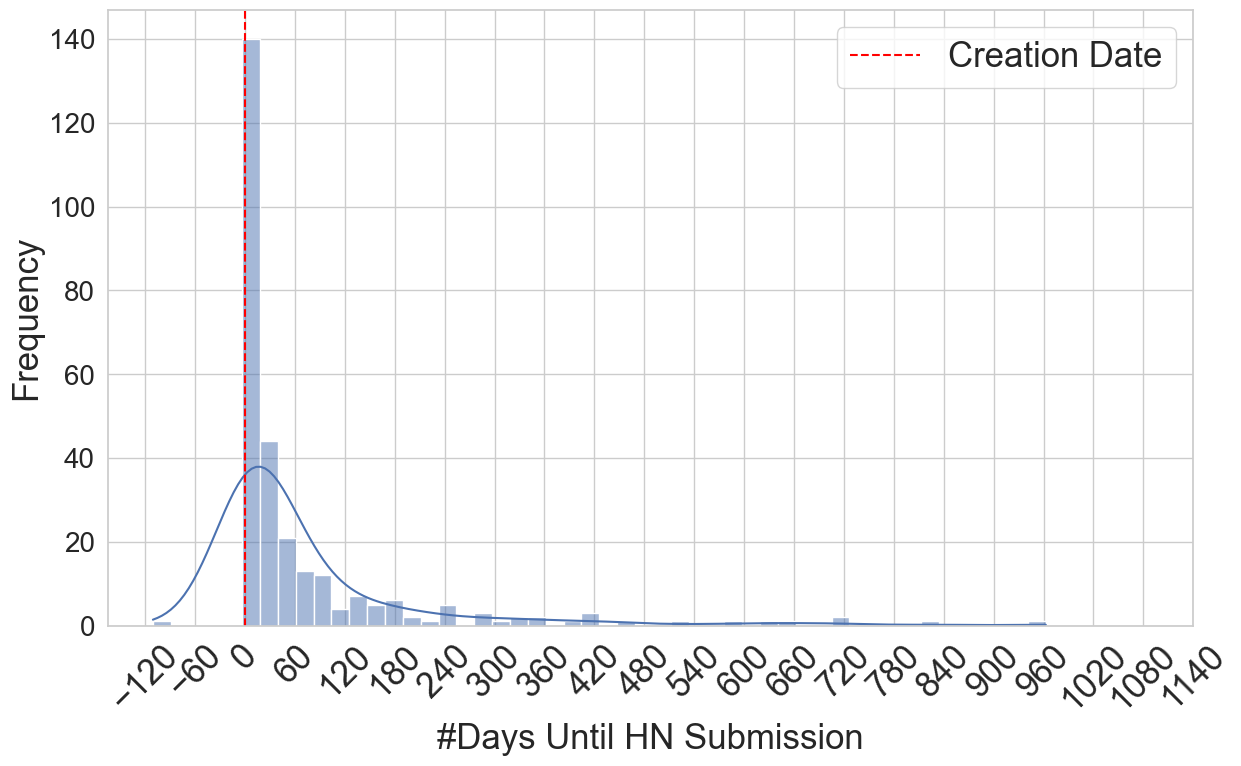

C:\Users\prach\AppData\Local\Temp\ipykernel_6976\1946454390.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='2M')


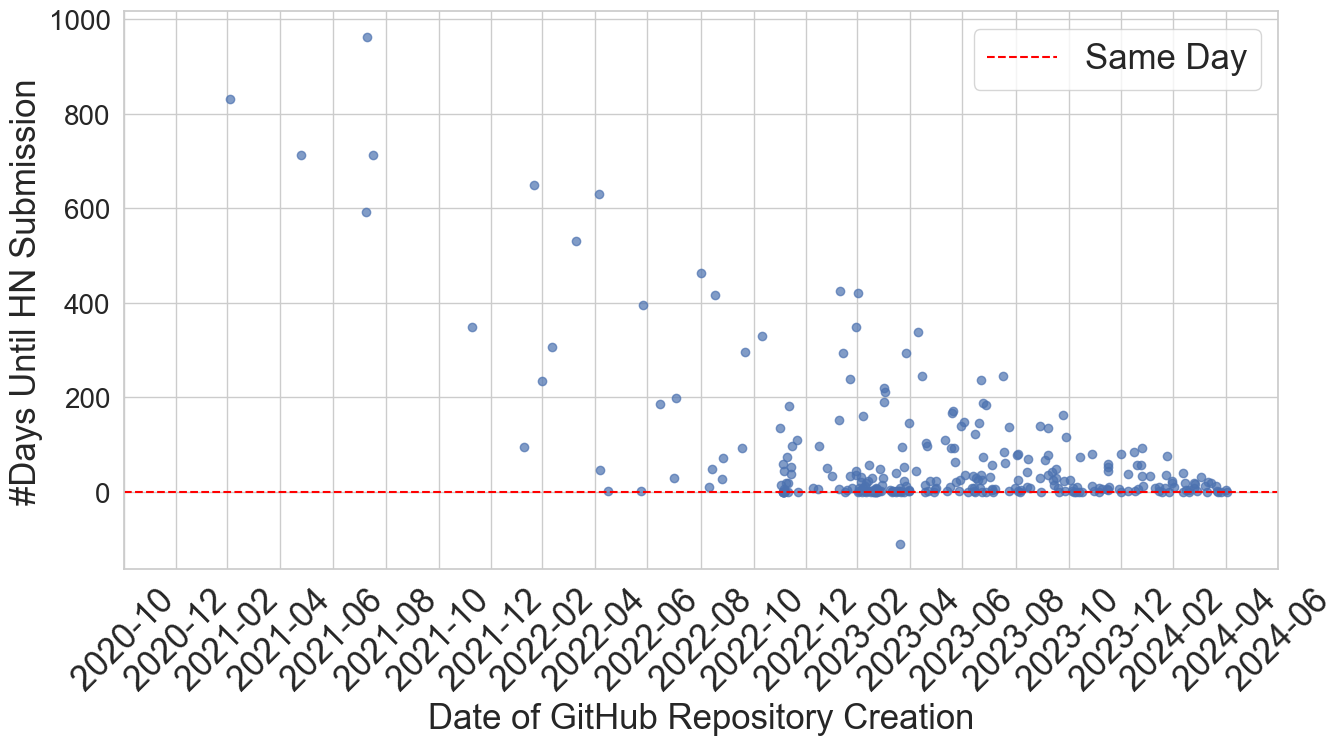

In [91]:
create_visualizations(merged_data)

In [ ]:
# Save the final dataset
HN_GH_METADATA_STORY_MERGED_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq3/rq3_creation_submission/rq3_github_hn_merged.csv'
merged_data.to_csv(HN_GH_METADATA_STORY_MERGED_CSV, index=False)
print(f'\nAnalysis complete! Results saved to {HN_GH_METADATA_STORY_MERGED_CSV}')